- Добавить другие признаки помимо лагов 
- Добавить валидацию не холдаут, а роллинг (или бэктестинг)
- Разные способы ансамблирования
- Разные датасеты под разные задачи

# Домашнее задание №2

### ИИ 2025-2026. Анализ временных рядов

**Выдано:** 28.01.2026

- **Мягкий дедлайн:** 11.02.2026 23:59
- **Жесткий дедлайн:** 18.02.2026 23:59

За каждый день просрочки после мягкого дедлайна снимается 1 балл.

```
Обратите внимание, что если у ассистента возникают подозрения по честному выполнению заданий (плагиат, чрезмерное использование LLM и/или использование LLM без указания промпта), то он может поставить вам устное собеседование по проделанной работе, по итогам которого он вправе обнулить вам работу.
```

Во второй домашней работе будем работать с ML моделями для прогнозирования временных рядов и рассмотрим несколько дополнительных сюжетов, которые не были затронуты на занятиях, но которые тесно с ними связаны.

В этот раз будем работать не в рамках одного ноутбука, а с использованием нескольких скриптов, которые находятся в папке `modules`. Это сделано для того, чтобы приблизить выполнение домашнего задания к реальным условиям работы с ML проектами.

В начале вас может напугать то, что теперь нужно работать с несколькими файлами, в которых еще и много кода но на самом деле большую часть кода мы уже разобрали на занятиях, и вам останется только реализовать несколько небольших функций и классов. Зато это позволит вам научиться работать с проектами, которые состоят из нескольких файлов, а также читать и понимать чужой код.

In [ ]:
import random
from typing import Sequence, Tuple, Union

# Будем использовать CatBoost в качестве базовой модели
import catboost as cb
import numpy as np
import pandas as pd

# Рисование графиков
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler

# Быстрый прогон бейзлайн моделей
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta, Naive, SeasonalNaive

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)


seed_everything()

На седьмом занятии мы рассмотрели с вами такую тему как стратегии прогнозирования на несколько шагов вперед. Мы рассмотрели несколько стратегий, но реализовали только Recursive, из которой вытекает Recursive-MIMO и MIMO. 

Давайте теперь реализуем еще одну стратегию — Direct (а заодно сразу получим и Direct-MIMO).  

### Задание 1: Загрузка данных и определение условий задачи прогнозирования (1 балл)

В этом задании возьмем датасет [METR-LA](https://drive.google.com/drive/folders/10FOTa6HXPqX8Pf5WRoRwcFnW9BrNZEIX), который содержит временные ряды скорости движения с 207 дорожных сенсоров, расположенных на автомагистралях округа Лос-Анджелес. Измерения агрегированы с шагом 5 минут и покрывают наблюдения с 2012-03-01 по 2012-06-28. 

Мы заранее сделали ресемплирование до 60 минут, а так же оставили только последние 10 недель данных (чтобы обучение не занимало слишком много времени) и 10 случайных рядов. Более того, мы привели данные к более удобному виду, где датафрейм представлен в виде трех столбцов: `timestamp`, `sensor_id`, `value`. 

__Подгрузите данные из файла `metr-la_preprocessed.csv` (0 баллов).__

In [ ]:
# --- Your code here ---

# Возьмем небольшой сэмпл для ускорения вычислений
random_ids = random.sample(df["sensor_id"].unique().tolist(), 10)
df = df[df["sensor_id"].isin(random_ids)].reset_index(drop=True)

__Выведите типы данных в датасете. Проверьте, что они корректные: даты должны быть в формате datetime, а значения — в float. id оставьте в int. Если это не так, то исправьте их (0.1 балла).__

In [ ]:
# --- Your code here ---

__Проверьте, есть ли в данных пропуски. Если они есть, то заполните их предыдущими значениями. Если пропусков нет, то просто выведите сообщение об этом (0.1 балла).__

In [ ]:
# --- Your code here ---

__Постройте линейные графики десяти случайных рядов из датасета. По оси X отложите время, по оси Y — значения временного ряда. Ответьте на вопросы ниже. (0.5 баллов)__

In [ ]:
# --- Your code here ---

__Ответьте на следующие вопросы:__
- Какова частотность (frequency) данных?
- Являются ли временные ряды выровненными (начинаются и заканчиваются в одно и то же время)?
- Стационарны ли временной ряд? Если нет, то какие признаки нестационарности вы можете выделить? Если в данных есть сезонность, по каков ее период?
- Похожи ли между собой разные временные ряды? Какие закономерности вы можете выделить?

__Для подтверждения периода сезонности постройте графики автокорреляционной функции (ACF) для трех рядов из нарисованных выше.__

__Замените нули временного ряда на локальное среднее в окне 5, чтобы избежать ложных пиков (0.3 балла).__ `Но не оставляйте их для следующих заданий (верните эти значения на 0).`

In [ ]:
# --- Your code here ---

Зафиксируем следующие параметры задачи прогнозирования:
- История (длина входного окна): 24 часа (24 точки при частоте 1 час)
- Горизонт прогнозирования (длина выходного окна): 12 часов (12 точек при частоте 1 час)
- Валидация: expanding (с расширяющимся окном обучения), шаг 1 неделя, начиная с 6 недель обучения. На валидационный набор отводится так же 1 неделя. Здесь валидационный набор — это те данные, которые используются для подбора гиперпараметров модели (в нашем случае early stopping).

In [ ]:
HISTORY = 24
HORIZON = 12
START_TRAIN_SIZE = 6 * 7 * 24  # 6 недель
STEP_SIZE = 7 * 24  # 1 неделя

SEASON_LENGTH = 24  # Суточная сезонность
FREQ = "h"  # Частота временного ряда, нужна для StatsForecast

### Задание 2: Реализация валидации с расширяющимся окном обучения и построение бейзлайнов при помощи statsforecast (1 балл)

__Дополните функцию валидации с расширяющимся окном обучения, которая находится в `modules/validation.py`.__

Обратите внимание, что валидационный датасет должен включать в себя `history` точек из конца трейна, помимо собственных 12 точек валидации. Аналогично, тестовый датасет должен включать в себя `history` точек из конца трейна + валидации, помимо собственных 12 точек теста.

Класс StatsforecastModel в `modules/models.py` написан за вас.

Давайте проверим, что всё сделано верно. 

In [ ]:
from modules.validation import expanding_window_validation
from modules.models import StatsforecastModel

from statsforecast.models import AutoETS, AutoTheta, Naive, SeasonalNaive

In [ ]:
all_results = {}

for model, model_name in [
    (StatsforecastModel(Naive(), FREQ, HORIZON), "Naive"),
    (StatsforecastModel(SeasonalNaive(season_length=SEASON_LENGTH), FREQ, HORIZON), "SeasonalNaive"),
    (StatsforecastModel(AutoETS(season_length=SEASON_LENGTH), FREQ, HORIZON), "AutoETS"),
    (StatsforecastModel(AutoTheta(season_length=SEASON_LENGTH), FREQ, HORIZON), "AutoTheta"),
]:
    print(f"Evaluating model: {model_name}")
    results_df = expanding_window_validation(
        data=df,
        model=model,
        horizon=HORIZON,
        history=HISTORY,
        start_train_size=START_TRAIN_SIZE,
        step_size=STEP_SIZE,
        id_col="sensor_id",
        timestamp_col="timestamp",
        value_col="value",
    )

    all_results[model_name] = results_df

Для того, чтобы проверить корректность реализации, проверьте получившиеся у вас графики с авторскими. Функцию для отрисовки графиков мы берем на себя :)

In [ ]:
all_results_df = (
    pd.concat(all_results.values(), keys=all_results.keys(), names=["model", "row_id"])
    .reset_index()
    .drop(columns=["row_id"])
)
all_results_df

In [ ]:
def plot_results_expanding_cv(
    df: pd.DataFrame,
    forecast_df: pd.DataFrame,
    id_column: str = "sensor_id",
    time_column: str = "timestamp",
    forecast_column: str = "predicted_value",
    target_column_df: str = "value",
    target_column_forecast_df: str = "true_value",
    fold_column_forecast_df: str = "fold",
    model_column_forecast_df: str = "model",
    num_samples_to_plot: int = 3,
    seed: int = 42,
):
    """Визуализирует expanding window CV.
    Args:
        df: Датафрейм с реальными значениями.
        forecast_df: Датафрейм с прогнозами и информацией о фолдах.
        id_column: Название колонки с идентификатором временного ряда.
        time_column: Название колонки с временной меткой.
        forecast_column: Название колонки с прогнозами.
        target_column_df: Название колонки с реальными значениями в df.
        target_column_forecast_df: Название колонки с реальными значениями в forecast_df.
        fold_column_forecast_df: Название колонки с фолдами в forecast_df.
        model_column_forecast_df: Название колонки с именами моделей в forecast_df.
        num_samples_to_plot: Количество случайных рядов для визуализации.
        seed: random seed для воспроизводимости.

    """
    colors = {
        "history_true": "grey",
        "forecast_true": "blue",
        "forecast_models": px.colors.qualitative.Plotly
    }
    
    random.seed(seed)
    sampled_ids = random.sample(
        forecast_df[id_column].dropna().unique().tolist(), num_samples_to_plot
    )

    num_folds = forecast_df[fold_column_forecast_df].nunique()
    for series_id in sampled_ids:
        current_df = df[df[id_column] == series_id]
        current_forecast_df = forecast_df[forecast_df[id_column] == series_id]

        fig = make_subplots(
            rows=num_folds,
            cols=1,
            shared_xaxes=True,
            vertical_spacing=0.12,
            subplot_titles=[f"fold={f}" for f in range(num_folds)],
        )

        for fold_idx in range(num_folds):
            current_fold_forecast_df = current_forecast_df[
                current_forecast_df[fold_column_forecast_df] == fold_idx
            ]
            test_start_timestamp = current_fold_forecast_df[time_column].min()

            history = current_df[current_df[time_column] < test_start_timestamp]

            fig.add_trace(
                go.Scatter(
                    x=history[time_column],
                    y=history[target_column_df],
                    mode="lines",
                    name="History (train+val)",
                    legendgroup="history",
                    line=dict(color=colors["history_true"]),
                    showlegend=(fold_idx == 0),
                ),
                row=fold_idx + 1,
                col=1,
            )
            for i, model_name in enumerate(sorted(
                current_fold_forecast_df[model_column_forecast_df].dropna().unique().tolist()
            )):                
                mdf = current_fold_forecast_df[
                    current_fold_forecast_df[model_column_forecast_df] == model_name
                ]
                if i == 0:
                    fig.add_trace(
                        go.Scatter(
                            x=mdf[time_column],
                            y=mdf[target_column_forecast_df],
                            mode="lines",
                            name="True (test)",
                            legendgroup="true_test",
                            line=dict(color=colors["forecast_true"]),
                            showlegend=(fold_idx == 0),
                        ),
                        row=fold_idx + 1,
                        col=1,
                    )
                fig.add_trace(
                    go.Scatter(
                        x=mdf[time_column],
                        y=mdf[forecast_column],
                        mode="lines",
                        line=dict(dash="dash", color=colors["forecast_models"][i % len(colors["forecast_models"])]),
                        name=str(model_name),
                        legendgroup=str(model_name),
                        showlegend=(fold_idx == 0),
                    ),
                    row=fold_idx + 1,
                    col=1,
                )
        fig.update_layout(
            title=f"Expanding CV: sensor_id={series_id}",
        )
        fig.show()

In [ ]:
plot_results_expanding_cv(df, all_results_df, num_samples_to_plot=1)

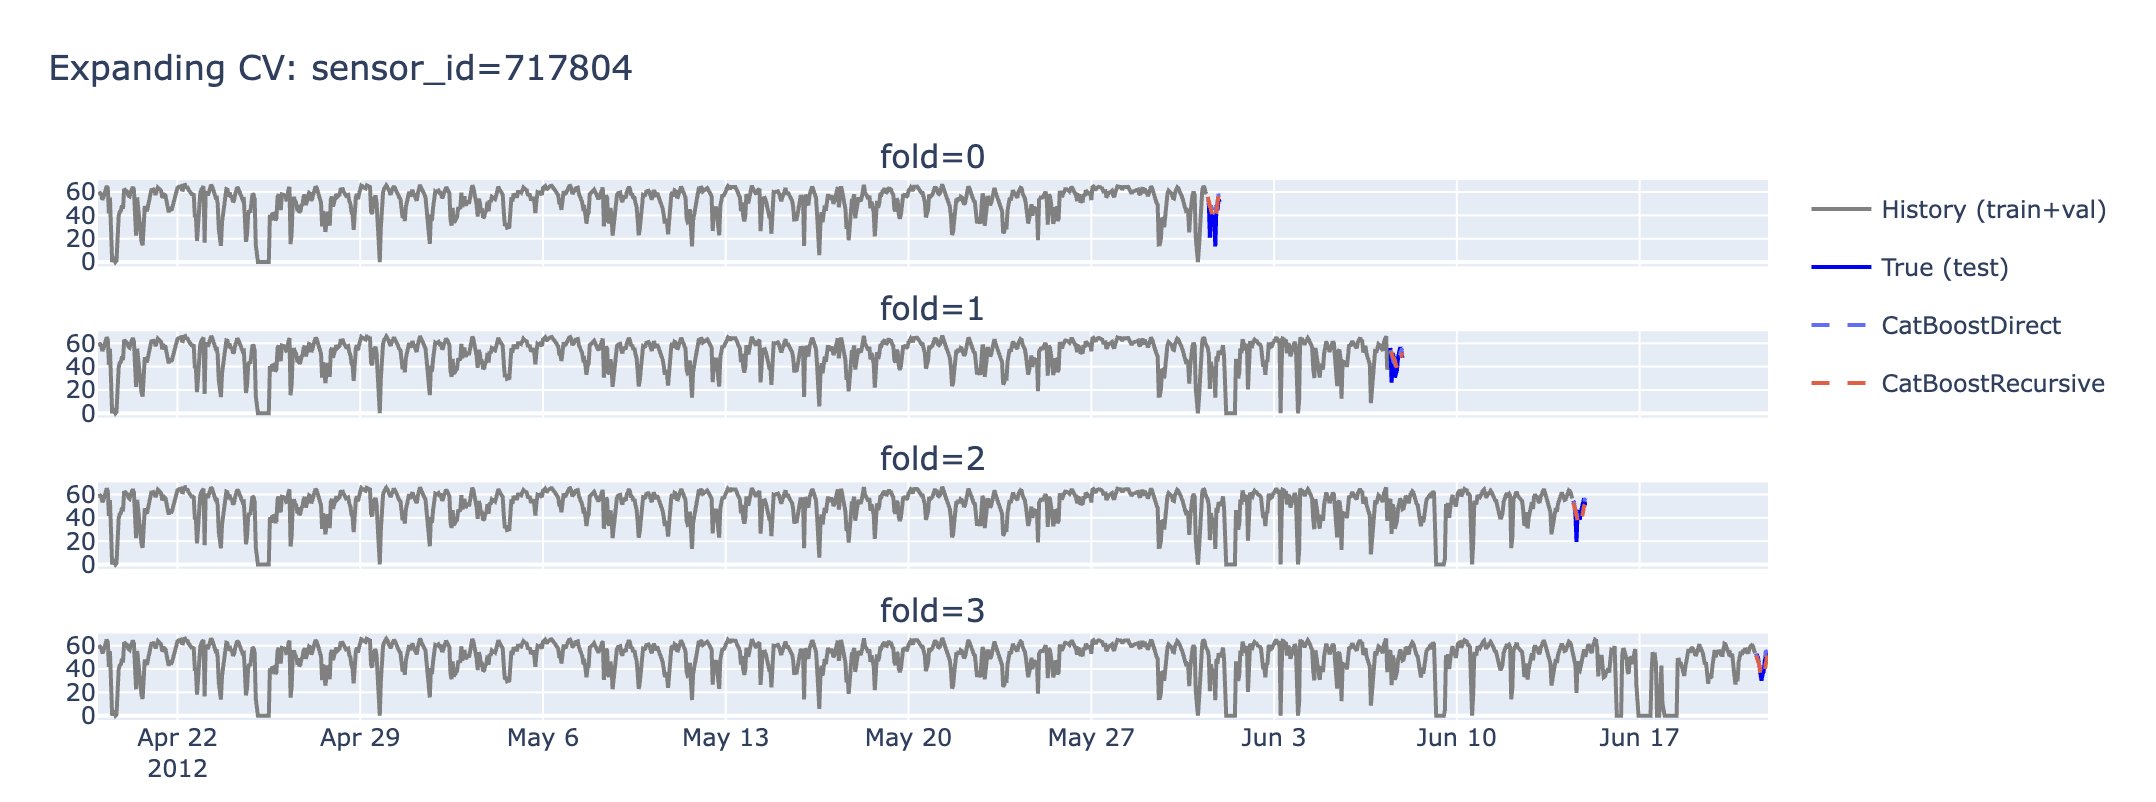

### Задание 3: Реализация метрик (0.5 балла)

Давайте будем использовать в качестве метрик ту, которую мы еще не брали ранее и которая была рекомендована в курсе [Christoph Bergmeir](https://www.youtube.com/watch?v=hrfEGmZjips) как еще одна замена классической метрики MAPE.

WAPE (Weighted Absolute Percentage Error) рассчитывается по формуле:

$$WAPE = \frac{\sum_{t=T+1}^{T+H} |y_t - \hat{y}_t|}{\sum_{t=T+1}^{T+H} |y_t|}$$

где:
- $H$ — горизонт прогнозирования
- $T$ — длина исторических данных
- $y_t$ — истинные значения временного ряда на горизонте прогнозирования
- $\hat{y}_t$ — предсказанные значения временного ряда на горизонте прогнозирования

От MAPE отличается тем, что суммы берутся вне дроби, что позволяет избежать деления на ноль и на малые значения. Можно сказать, что мы взвешиваем общую абсолютную ошибку по абсолютным значениям временного ряда (сколько процентов от общего объема мы ошиблись). 

__Реализуйте расчет этих метрик в функции `calculate_metrics`.__

In [ ]:
def calculate_wape(
    group: pd.DataFrame, pred_column: str = "predicted_value", true_column: str = "true_value"
) -> pd.Series:
    """Вычисляет метрику WAPE.

    Args:
        group: Датафрейм с прогнозами и реальными значениями.
        pred_column: Название колонки с прогнозами.
        true_column: Название колонки с реальными значениями.

    Returns:
        pd.Series с рассчитанной метрикой WAPE.

    """
    # --- Your code here ---
    return pd.Series({"WAPE": wape})

Если всё сделано правильно, то следующая ячейка запуститься без ошибок.

In [ ]:
metrics_df = (
    all_results_df
    .groupby(["model", "fold"], as_index=False)
    .apply(calculate_wape, include_groups=False)
    .reset_index(drop=True)
)

print("WAPE по моделям и фолдам:")
display(metrics_df)

print("Среднее и стандартное отклонение WAPE по моделям:")
display(metrics_df.groupby("model").agg({"WAPE": ["mean", "std"]}))

### Задание 4: Реализация Direct и Direct-MIMO (4.5 балла)

__Реализуйте модель CatBoostDirect в файле `modules/models.py`__ аналогично тому, как мы реализовали стратегию Recursive на семинаре. Для примера CatBoostRecursive модель уже приведена в формате класса.

Обратите внимание, что все нужные функции для работы с индексами находятся в файле `modules/index_slicing.py`.

Если в случае с рекурсивной стратегией в случае `model_horizon=1` мы обучали одну модель на один шаг вперед, то в случае с Direct стратегией нам нужно обучать по одной модели на каждый шаг из горизонта прогнозирования. То есть в аттрибутах класса CatBoostDirect self.models должно быть $H$ моделей CatBoost, где $H$ — горизонт прогнозирования.

__Вам необходимо понять, как изменить код рекурсивной стратегии так, чтобы реализовать Direct стратегию.__

Если все сделано правильно, то следующие ячейки должны запуститься без ошибок.

In [ ]:
from modules.models import CatBoostRecursive, CatBoostDirect

In [ ]:
recursive_results = expanding_window_validation(
    data=df,
    model=CatBoostRecursive(
        model_horizon=1,
        history=HISTORY,
        horizon=HORIZON,
        freq=FREQ,
    ),
    horizon=HORIZON,
    history=HISTORY,
    start_train_size=START_TRAIN_SIZE,
    step_size=STEP_SIZE,
    id_col="sensor_id",
    timestamp_col="timestamp",
    value_col="value",
)

In [ ]:
direct_results = expanding_window_validation(
    data=df,
    model=CatBoostDirect(
        model_horizon=1,
        history=HISTORY,
        horizon=HORIZON,
        freq=FREQ,
    ),
    horizon=HORIZON,
    history=HISTORY,
    start_train_size=START_TRAIN_SIZE,
    step_size=STEP_SIZE,
    id_col="sensor_id",
    timestamp_col="timestamp",
    value_col="value",
)

In [ ]:
ml_results_df = pd.concat(
    [
        recursive_results.assign(model="CatBoostRecursive"),
        direct_results.assign(model="CatBoostDirect"),
    ],
    ignore_index=True,
)
ml_results_df

In [ ]:
plot_results_expanding_cv(df, ml_results_df, num_samples_to_plot=1)

In [ ]:
metrics_df = (
    ml_results_df
    .groupby(["model", "fold"], as_index=False)
    .apply(calculate_wape, include_groups=False)
    .reset_index(drop=True)
)

print("WAPE по моделям и фолдам:")
display(metrics_df)

print("Среднее и стандартное отклонение WAPE по моделям:")
display(metrics_df.groupby("model").agg({"WAPE": ["mean", "std"]}))

### Задание 5: Сравнение моделей (2 балла)

Возьмите промежуточный вариант стратегий (Direct-MIMO и Recursive-MIMO) с model_horizon = 3. Также возьмите не 10 рядов, а хотя бы 30. Сравните качество получившихся моделей с качеством полных Direct, Recursive и MIMO стратегий (model_horizon = 1). Какой из вариантов показал себя лучше? Почему, на ваш взгляд, так произошло?

In [ ]:
# --- Your code here ---

### Задание 6: Добавим больше фичей (1 балл)

Добавьте в функции `get_features_df_and_targets` из файла `modules/feature_generation.py` добавьте несколько оконных признаков (например, скользящие средние или std). Проверьте, улучшилось ли качество лучшей модели при добавлении этих признаков.

In [ ]:
# --- Your code here ---

## Бонус (до 3-х баллов):

Попробуйте найти узкие места в коде и оптимизировать его, чтобы обучение и предсказание происходило быстрее. Например, можно попробовать параллелить обучение моделей при помощи многопоточности или многопроцессорности. 

- 3 балла вы получите, если найдете хотя бы 2 способа оптимизации кода и сможете сократить время обучения и Recusive и Direct стратегий до такого значения, чтобы вы смогли получить результаты всех стратегий на всем датасете (207 рядов).
- Меньшее количество баллов будет выставлено в зависимости от того, сколько способов оптимизации вы найдете и насколько сильно сократится время обучения и предсказания.

In [ ]:
# --- Your code here ---